In [1]:
import keras
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator ,img_to_array,load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib

Using TensorFlow backend.


In [2]:
with open("fer2013") as f:
    content = f.readlines()
    lines = np.array(content)
num_of_instances = lines.size
print("number of instances: ",num_of_instances)

number of instances:  35918


In [3]:

num_classes=7
x_train, y_train, x_test, y_test,x,y = [], [], [], [],[],[]
 
for i in range(1,num_of_instances):
 try:
  emotion, img, usage = lines[i].split(",")
 
  val = img.split(" ")
  pixels = np.array(val, 'float32')
  x.append(pixels)
  y.append(emotion)
 except:
  print("", end="")

In [4]:
x=np.array(x).reshape(-1,48,48,1)
x=x/255.0
y=np.array(y)
lb = LabelBinarizer()
y = lb.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(28709, 7)
(7178, 48, 48, 1)
(7178, 7)


In [5]:
def build(width,height,depth,classes):

    model=Sequential()
    inputShape=(height,width,depth)

    #first layer
    model.add(Conv2D(32,(3,3),input_shape=inputShape,padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))


    #second layer
    model.add(Conv2D(64, (3, 3),padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(64, (3, 3),padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.30))

    #third layer
    model.add(Conv2D(128, (3, 3),padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3),padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model



In [6]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.2,height_shift_range=0.3, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")
BS=256
EPOCHS=50
INIT_LR=.001
print("[INFO] compiling model...")
model = build(width=48, height=48,depth=1, classes=len(lb.classes_))
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

filepath="trained.hdf5"
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(x,y, batch_size=BS),
    steps_per_epoch=len(x) // BS,
    epochs=EPOCHS, verbose=1)
model.save(filepath)

[INFO] compiling model...
[INFO] training network...
Epoch 1/50
140/140 [==============================] - 39s 278ms/step - loss: 2.4162 - acc: 0.2026
Epoch 2/50
140/140 [==============================] - 32s 229ms/step - loss: 1.9669 - acc: 0.2356
Epoch 3/50
140/140 [==============================] - 32s 227ms/step - loss: 1.8640 - acc: 0.2617
Epoch 4/50
140/140 [==============================] - 32s 227ms/step - loss: 1.8486 - acc: 0.2715
Epoch 5/50
140/140 [==============================] - 32s 227ms/step - loss: 1.8068 - acc: 0.2853
Epoch 6/50
140/140 [==============================] - 32s 227ms/step - loss: 1.7628 - acc: 0.3122
Epoch 7/50
140/140 [==============================] - 32s 230ms/step - loss: 1.7190 - acc: 0.3366
Epoch 8/50
140/140 [==============================] - 32s 230ms/step - loss: 1.6635 - acc: 0.3636
Epoch 9/50
140/140 [==============================] - 32s 230ms/step - loss: 1.6622 - acc: 0.3660
Epoch 10/50
140/140 [==============================] - 32s 230ms/

In [ ]:
import cv2
from keras.preprocessing.image import img_to_array
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
image= cv2.imread('sad.jpg',cv2.IMREAD_GRAYSCALE)
#output = image.copy()
#cv2.imshow('image',image)
# pre-process the image for classification
image = cv2.resize(image, (48, 48))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
proba=model.predict(image)
print(proba)
idx = np.argmax(proba)

print(emotions[idx])

In [ ]:
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(args["plot"])

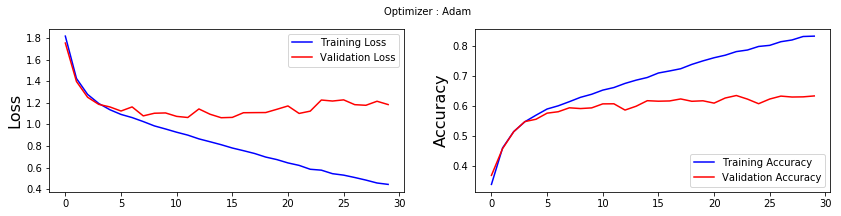

In [54]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()
